# Logistic Regression

This is an example of performing logistic regression in Python with the Scikit-learn module. In this example, we perform many useful python functions beyond what we need for a simple model. This is done partially to explore some more advanced modeling, array manipulation, evaluation, and so on. We will also use several external modules importing data, formatting data, manipulating data, modeling and graphical exploration.

# Dataset

The dataset I chose for this example in Longitudinal Low Birth Weight Study (CLSLOWBWT.DAT). Hosmer and Lemeshow (2000) Applied Logistic Regression: Second Edition. These data are copyrighted by John Wiley & Sons Inc. and must be acknowledged and used accordingly.


# List of Variables

Variable Description Codes/Values Name

    1. Identification Code ID Number ID
    2. Birth Number 1-4 BIRTH
    3. Smoking Status 0 = No, 1 = Yes SMOKE During Pregnancy
    4. Race 1 = White, 2 = Black RACE 3 = Other
    5. Age of Mother Years AGE
    6. Weight of Mother at Pounds LWT Last Menstrual Period
    7. Birth Weight Grams BWT
    8. Low Birth Weight 1 = BWT <=2500g, LOW 0 = BWT >2500g


# Problem Statement

In this example, we want to predict Low Birth Weight using the remaining dataset variables. Low Birth Weight, the dependent variable, 1 = BWT <=2500g and 0 = BWT >2500g.


# Important Modules

In [76]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
%matplotlib inline

import graphlab as gl
import graphlab
# keep data visualizations within notebook
graphlab.canvas.set_target('ipynb')

In [73]:
PATH = 'data\\'

# Data Pre-Processing

In [74]:
# load dataset dta
CLS_LOW_BWT_FILENAME = PATH +  "CLSLOWBWT.csv"
dta = pd.read_csv(CLS_LOW_BWT_FILENAME)

# Data Exploration

In [6]:
dta.groupby('LOW').mean()

,ID,BIRTH,SMOKE,RACE,AGE,LWT,BWT
LOW,,,,,,,
0,92.875371,1.836795,0.338279,1.976261,26.163205,144.741840,3204.059347
1,95.092715,1.953642,0.536424,1.576159,27.059603,138.304636,2033.867550


We can see that on average, women who have children with a low birth weight are more likely to be smokers than nonsmokers. This makes sense based on scientific studies. Let's take another look at the Birth Number variable.

In [7]:
dta.groupby('BIRTH').mean()

,ID,SMOKE,RACE,AGE,LWT,BWT,LOW
BIRTH,,,,,,,
1,94.500000,0.393617,1.851064,22.819149,129.851064,2848.159574,0.281915
2,94.500000,0.393617,1.851064,26.930851,150.638298,2857.367021,0.303191
3,89.091837,0.408163,1.857143,31.153061,150.520408,2838.153061,0.367347
4,99.642857,0.500000,1.857143,35.500000,155.642857,2578.857143,0.357143


Low Birth Weight trends upward with more births.

# Data Visualization

In [ ]:
# show plots in the notebook %matplotlib inline

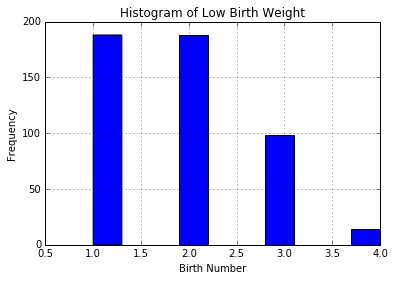

In [11]:
# histogram of birth number
dta.BIRTH.hist() 
plt.title('Histogram of Low Birth Weight')
plt.xlabel('Birth Number')
plt.ylabel('Frequency')

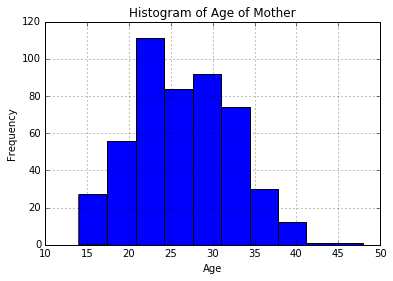

In [12]:
# histogram of age of mother
dta.AGE.hist() 
plt.title('Histogram of Age of Mother')
plt.xlabel('Age')
plt.ylabel('Frequency')

Let's take a look at the distribution of smokers for those having children with low birth weights versus those who do not.

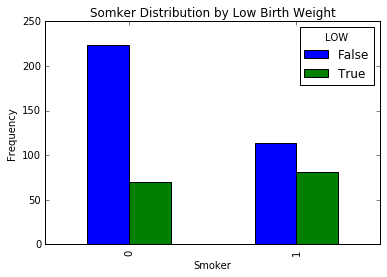

In [13]:
# barplot of low birth weights grouped by smoker status (True or False)
pd.crosstab(dta.SMOKE, 
            dta.LOW.astype(bool)).plot(kind='bar')
plt.title('Somker Distribution by Low Birth Weight')
plt.xlabel('Smoker')
plt.ylabel('Frequency')

Now let's use a stacked barplot to look at the percentage of women having children with low birth weights by age.

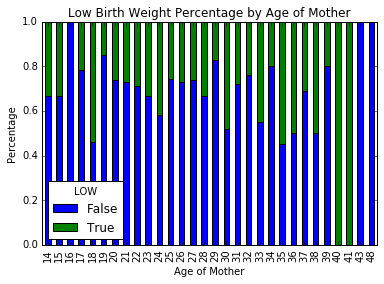

In [14]:
low_age = pd.crosstab(dta.AGE, dta.LOW.astype(bool))
low_age.div(low_age.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Low Birth Weight Percentage by Age of Mother')
plt.xlabel('Age of Mother')
plt.ylabel('Percentage')

# Prepare Data for Logistic Regression

To prepare the data, we want to add an intercept column as well as dummy variables for Age of Mother and Weight of Mother at Last Menstrual Period, since we are treating them as categorical variables. The "dmatrices" function from the patsy module can do that using formula language.
The column names for the dummy variables are messy, so let's rename those.

In [16]:
# create dataframes with an intercept column and dummy variables for
y, X = dmatrices('LOW ~ ID + BIRTH + SMOKE + RACE + AGE + LWT', 
                 dta, 
                 return_type="dataframe")
print X.columns

Index([u'Intercept', u'ID', u'BIRTH', u'SMOKE', u'RACE', u'AGE', u'LWT'], dtype='object')


We now want to convert the numeric (interval) variable AGE to a categorical variable with 4 classes.
We also need to flatten y into a 1-D array, so that Scikit-learn will properly understand it as the response variable.

In [17]:
# flatten y into a 1-D array
y = np.ravel(y)

# First Logistic Regression

Let's go ahead and run logistic regression on the entire data set, and see how accurate it is.

In [19]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression() 
model = model.fit(X, y)
# check the accuracy on the training set
model.score(X, y)

0.70696721311475408

70.7% accuracy seems good, but what's the null error rate?

In [20]:
# what percentage had low birth weights?
y.mean()

0.3094262295081967

Only 31% of the women had low birth rate children, which means that you could obtain 69% accuracy by always predicting "no". So we're doing better than the null error rate, but not by much. Let's examine the coefficients to see what we learn.

In [21]:
# examine the coefficients 
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[0.0336484036189]
1,ID,[0.00231314008477]
2,BIRTH,[0.185995251421]
3,SMOKE,[0.546655639347]
4,RACE,[-0.413795537976]
5,AGE,[0.0257483072668]
6,LWT,[-0.0115073134923]


# Converting Variables & Merging Dataframes

Now, we want to take the variable AGE and convert it to a categorical variable, to see if we can improve the model. We will do this by creating two data frames from our original data. we will then merge the two data frames, so both need to contain the ID variable. One data from will have the converted categorical variable age_group, and the other will have the dependent variable and the other independent variables.

In [23]:
df1 = pd.DataFrame(dta, columns=['ID','AGE'])
df2 = pd.DataFrame(dta, columns=['ID', 'BIRTH', 'SMOKE', 'RACE', 'LWT', 'LOW'])
bins = [15, 25, 35, 45, 55]
group_names = ['15-24', '25-34', '35-44', '45-55']
age_groups = pd.cut(df1['AGE'], bins, labels=group_names)
df1['age_groups'] = pd.cut(df1['AGE'], bins, labels=group_names)
df1.head(5)

,ID,AGE,age_groups
0,1,28,25-34
1,1,33,25-34
2,2,29,25-34
3,2,34,25-34
4,2,37,35-44


# We now merge the two data frames.

In [26]:
left = df2 
right = df1 
result = pd.merge(left, right, on='ID') 
result.head(5)

,ID,BIRTH,SMOKE,RACE,LWT,LOW,AGE,age_groups
0,1,1,1,3,120,0,28,25-34
1,1,1,1,3,120,0,33,25-34
2,1,2,1,3,141,0,28,25-34
3,1,2,1,3,141,0,33,25-34
4,2,1,0,1,130,0,29,25-34


# Second Logistic Regression
We are now ready to build and evaluate our second logistic regression model, using the merged data frames.

In [27]:
y, Z = dmatrices('LOW ~ BIRTH + SMOKE + RACE + age_groups + LWT', result, return_type="dataframe")
print Z.columns

Index([u'Intercept', u'age_groups[T.25-34]', u'age_groups[T.35-44]',
       u'age_groups[T.45-55]', u'BIRTH', u'SMOKE', u'RACE', u'LWT'],
      dtype='object')


Since we change the size of y when we converted AGE and merged, we also need to flatten y again into a 1-D array, so that Scikit-learn will properly understand it as the response variable

In [28]:
# flatten y into a 1-D array
y = np.ravel(y)

Before we perform the logistic regression, we want to check the matrix we just formed to ensure it is consistent with our intent.

In [30]:
Z.head(5)

,Intercept,age_groups[T.25-34],age_groups[T.35-44],age_groups[T.45-55],BIRTH,SMOKE,RACE,LWT
0,1.0,1.0,0.0,0.0,1.0,1.0,3.0,120.0
1,1.0,1.0,0.0,0.0,1.0,1.0,3.0,120.0
2,1.0,1.0,0.0,0.0,2.0,1.0,3.0,141.0
3,1.0,1.0,0.0,0.0,2.0,1.0,3.0,141.0
4,1.0,1.0,0.0,0.0,1.0,0.0,1.0,130.0


Finally, we are ready to execute the logistic regression model and see how accurate it is.

In [32]:
# instantiate a logistic regression model, and fit with X and y
model1 = LogisticRegression() 
model1 = model1.fit(Z, y)
# check the accuracy on the training set
model1.score(Z, y)

0.71320754716981127

71.3% accuracy seems good, but what's the null error rate? We also want to recheck the percentage of low birth weights

In [34]:
# what percentage had low birth weights? 
y.mean()

0.30867924528301888

Still, only 31% of the women had low birth rate children, which means that you could obtain 69% accuracy by always predicting "no". So we're doing better than the null error rate, but not by much. Let's examine the coefficients to see what we learn.

In [35]:
# examine the coefficients
pd.DataFrame(zip(Z.columns, np.transpose(model.coef_)))

,0,1
0,Intercept,[0.0336484036189]
1,age_groups[T.25-34],[0.00231314008477]
2,age_groups[T.35-44],[0.185995251421]
3,age_groups[T.45-55],[0.546655639347]
4,BIRTH,[-0.413795537976]
5,SMOKE,[0.0257483072668]
6,RACE,[-0.0115073134923]


Increases in Birth Number and RACE correspond to a decrease in the likelihood of having an Low Birth Weight child. A decrease in Smoking Status corresponds to a decrease in the likelihood of having an Low Birth Weight child. For Age Group, the lowest likelihood of having Low Birth Weight child corresponds to the baseline age group (15-24), since all of the dummy coefficients are positive.

# Model Evaluation Using a Validation Set

So far, we have trained and tested on the same set. Let's instead split the data into a training set and a testing set.

In [38]:
# evaluate the model by splitting into train and test sets
Z_train, Z_test, y_train, y_test = train_test_split(Z, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=0) 
model2 = LogisticRegression()
model2.fit(Z_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
# predict class labels for the test set
predicted = model2.predict(Z_test)

In [40]:
print predicted

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  1.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.
  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  1.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0

In [42]:
# generate class probabilities p
probs = model2.predict_proba(Z_test)
print probs

[[ 0.70610757  0.29389243]
 [ 0.82942743  0.17057257]
 [ 0.78996271  0.21003729]
 [ 0.71714884  0.28285116]
 [ 0.82860543  0.17139457]
 [ 0.66919893  0.33080107]
 [ 0.80411336  0.19588664]
 [ 0.82942743  0.17057257]
 [ 0.80489925  0.19510075]
 [ 0.76636931  0.23363069]
 [ 0.65336844  0.34663156]
 [ 0.73297998  0.26702002]
 [ 0.78927393  0.21072607]
 [ 0.68660728  0.31339272]
 [ 0.47777583  0.52222417]
 [ 0.48227767  0.51772233]
 [ 0.65248622  0.34751378]
 [ 0.76164841  0.23835159]
 [ 0.67351301  0.32648699]
 [ 0.86128674  0.13871326]
 [ 0.76963284  0.23036716]
 [ 0.72272822  0.27727178]
 [ 0.8737568   0.1262432 ]
 [ 0.88208189  0.11791811]
 [ 0.53068538  0.46931462]
 [ 0.70610757  0.29389243]
 [ 0.7541737   0.2458263 ]
 [ 0.5221264   0.4778736 ]
 [ 0.35235687  0.64764313]
 [ 0.7779275   0.2220725 ]
 [ 0.88745073  0.11254927]
 [ 0.55386162  0.44613838]
 [ 0.78469494  0.21530506]
 [ 0.76285017  0.23714983]
 [ 0.911691    0.088309  ]
 [ 0.87598835  0.12401165]
 [ 0.44136563  0.55863437]
 

As you can see, the classifier is predicting a 1 (having a Low Birth Weight child) any time the probability in the second column is greater than 0.5. Now let's generate some evaluation metrics.

In [43]:
# generate evaluation metrics
print metrics.accuracy_score(y_test, predicted)
print metrics.roc_auc_score(y_test, probs[:, 1])

0.678391959799
0.678443267259


The accuracy is 67.8%, which is the close to what we experienced when training and predicting on the same data. We can also see the confusion matrix and a classification report with other metrics.

In [44]:
print metrics.confusion_matrix(y_test, predicted)
print metrics.classification_report(y_test, predicted)

[[239  27]
 [101  31]]
             precision    recall  f1-score   support

        0.0       0.70      0.90      0.79       266
        1.0       0.53      0.23      0.33       132

avg / total       0.65      0.68      0.64       398



# Model Evaluation Using Cross-Validation
Now let's try 10-fold cross-validation, to see if the accuracy holds up more rigorously.

In [45]:
# evaluate the model using 10-fold cross-validation
scores = cross_val_score(LogisticRegression(), 
                         Z, 
                         y, 
                         scoring='accuracy', 
                         cv=10)
print scores
print scores.mean()

[ 0.53383459  0.7518797   0.69924812  0.68421053  0.64661654  0.80451128
  0.73484848  0.66666667  0.61363636  0.71755725]
0.685300951894


Looks good. It's still performing at 69% accuracy.

# Predicting the Probability of Low Birth Weight Child
Just for fun, let's predict the probability of a low birth weight child for a random woman not present in the dataset. She's a 35-year-old Other race, has had 2 births,(has 2 children), is a smoker, and her weight is 132.

In [47]:
model.predict_proba(np.array([0, 0, 1, 1, 3, 2, 1]))

C:\Users\Ben\Anaconda6\envs\gl-env\lib\site-packages\sklearn\utils\validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


array([[ 0.60709037,  0.39290963]])

The predicted probability of low birth weight child is 39.3%

# Next Steps
There are many different steps that could be tried in order to improve the model:

    including interaction terms
    removing features
    regularization techniques
    using a non-linear model

# Turi Machine Learning Platform User Guide

# Graph Lab Create

# Logistic Regression 

Logistic regression is a regression model that is popularly used for classification tasks. In logistic regression, the probability that a **binary target is True** is modeled as a [logistic function](http://en.wikipedia.org/wiki/Logistic_function) of a linear combination of features. The following figure illustrates how logistic regression is used to train a 1-dimensional classifier. The training data consists of positive examples (depicted in blue) and negative examples (in orange). The decision boundary (depicted in pink) separates out the data into two classes. 

In [48]:
import graphlab as gl
import graphlab
# keep data visualizations within notebook
graphlab.canvas.set_target('ipynb')

# Load the data
data =  gl.SFrame('https://static.turi.com/datasets/regression/yelp-data.csv')

# Restaurants with rating >=3 are good
data['is_good'] = data['stars'] >= 3

# Make a train-test split
train_data, test_data = data.random_split(0.8)

# Create a model.
model = gl.logistic_classifier.create(train_data, 
                                      target='is_good',
                                      features = ['user_avg_stars',
                                                'business_avg_stars',
                                                'user_review_count',
                                                'business_review_count'])

# Save predictions (probability estimates) to an SArray
predictions = model.classify(test_data)

# Evaluate the model and save the results into a dictionary
results = model.evaluate(test_data)

This non-commercial license of GraphLab Create for academic use is assigned to bbrock@smu.edu and will expire on August 17, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: C:\Users\Ben\AppData\Local\Temp\graphlab_server_1475177132.log.0


Downloading https://static.turi.com/datasets/regression/yelp-data.csv to C:/Users/Ben/AppData/Local/Temp/graphlab-BenBrock/14784/84a263ff-e7d4-46d9-b0c9-981e49f73d4e.csv

Finished parsing file https://static.turi.com/datasets/regression/yelp-data.csv

Parsing completed. Parsed 100 lines in 0.533553 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[str,str,str,long,str,str,str,dict,long,long,long,list,str,str,float,float,str,long,long,float,str,str,float,str,long,str,long,long,long,dict]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Read 47948 lines. Lines per second: 15458.7

Finished parsing file https://static.turi.com/datasets/regression/yelp-data.csv

Parsing completed. Parsed 215879 lines in 4.92398 secs.

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Logistic regression:

--------------------------------------------------------

Number of examples          : 163805

Number of classes           : 2

Number of feature columns   : 4

Number of unpacked features : 4

Number of coefficients    : 5

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 1.188729     | 0.863747          | 0.862951            |

| 2         | 3        | 1.310838     | 0.866726          | 0.866456            |

| 3         | 4        | 1.403904     | 0.867122          | 0.866690            |

| 4         | 5        | 1.486963     | 0.867251          | 0.867274            |

| 5         | 6        | 1.564018     | 0.867269          | 0.867274            |

| 6         | 7        | 1.645076     | 0.867269          | 0.867274            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

Advanced Usage

Refer to the chapter on linear regression for the following features:

    Accessing attributes of the model
    Interpreting results
    Using categorical features
    Sparse features
    List features
    Feature rescaling
    Chosing the solver
    Regularizing models

We will now discuss some advanced features that are specific to logistic regression.
Making Predictions

Predictions using a GraphLab Create classifier is easy. The classify() method provides a one-stop shop for all that you need from a classifier.

    A class prediction
    Probability/Confidence associated with that class prediction.

In the following example, the first prediction was class 1 with a 90.5% probability.

In [49]:
predictions = model.classify(test_data)
print predictions

+-------+----------------+
| class |  probability   |
+-------+----------------+
|   1   | 0.939273077702 |
|   1   | 0.948592772612 |
|   1   | 0.922095906969 |
|   1   | 0.702785257426 |
|   1   | 0.874493206834 |
|   1   | 0.780606542486 |
|   1   | 0.905959532362 |
|   1   | 0.958010479264 |
|   1   | 0.974481896863 |
|   1   | 0.881426373714 |
+-------+----------------+
[43515 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


Making detailed predictions

Logistic regression predictions can take one of three forms:

    Classes (default): Thresholds the probability estimate at 0.5 to predict
    a class label i.e. 0/1.
    Probabilities: A probability estimate (in the range [0,1]) that the example is in the True class. Note that this is not the same as the probability estimate in the classify function.
    Margins : Distance to the linear decision boundary learned by the model. The larger the distance, the more confidence we have that it belongs to one class or the other.

GraphLab Create's logistic regression model can return predictions for any of these types:

In [50]:
pred_class = model.predict(test_data, output_type = "class")          # Class
pred_prob_one = model.predict(test_data, output_type = 'probability') # Probability
pred_margin = model.predict(test_data, output_type = "margin")        # Margins

 Evaluating Results

We can also evaluate our predictions by comparing them to known ratings. The results are evaluated using two metrics:

    Classification Accuracy: Fraction of test set examples with correct class label predictions.
    Confusion Matrix: Cross- tabulation of predicted and actual class labels.


In [51]:
result = model.evaluate(test_data)
print "Accuracy         : %s" % result['accuracy']
print "Confusion Matrix : \n%s" % result['confusion_matrix']

Accuracy         : 0.864345627944
Confusion Matrix : 
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|      1       |        0        |  964  |
|      0       |        0        |  2318 |
|      0       |        1        |  4939 |
|      1       |        1        | 35294 |
+--------------+-----------------+-------+
[4 rows x 3 columns]



# Logistic Regression Model

# Load the data into a SFrame

In [75]:
# Load the data
sf_data =  gl.SFrame(CLS_LOW_BWT_FILENAME)

Finished parsing file G:\jhu\smu\classes\MSDS-7331-Data-Mining-402\lectures\mini-lab\data\CLSLOWBWT.csv

Parsing completed. Parsed 100 lines in 0.017027 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[long,long,long,long,long,long,long,long]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


Finished parsing file G:\jhu\smu\classes\MSDS-7331-Data-Mining-402\lectures\mini-lab\data\CLSLOWBWT.csv

Parsing completed. Parsed 488 lines in 0.017024 secs.

**Logistic Regression Model Setup** 

### Assess how well each model performs (use 80/20) training/testing split for your data

In [53]:
# Make a train-test split
train_data, test_data = sf_data.random_split(0.8)

In [54]:
sf_data.show()

In [61]:
print "Number of items in the array: {}".format(len(sf_data['LOW']))

Number of items in the array: 488


## Logistic Regression Model Equation

### LOW ~ ID + BIRTH + SMOKE + RACE + AGE + LWT

In [55]:
'''
Here, we have created our custom features based on the data set.
'''
my_custom_features = ['ID', 
                      'BIRTH' , 
                      'SMOKE', 
                      'RACE',
                      'AGE',
                      'LWT']

In [56]:
# Make a logistic regression model
# The model is trained with the training data (train_data)
model = graphlab.logistic_classifier.create(train_data, 
                                            target = 'LOW', 
                                            features = my_custom_features)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.



Logistic regression:

--------------------------------------------------------

Number of examples          : 372

Number of classes           : 2

Number of feature columns   : 6

Number of unpacked features : 6

Number of coefficients    : 7

Starting Newton Method

--------------------------------------------------------

+-----------+----------+--------------+-------------------+---------------------+

| Iteration | Passes   | Elapsed Time | Training-accuracy | Validation-accuracy |

+-----------+----------+--------------+-------------------+---------------------+

| 1         | 2        | 0.001001     | 0.709677          | 0.625000            |

| 2         | 3        | 0.002002     | 0.723118          | 0.583333            |

| 3         | 4        | 0.002002     | 0.723118          | 0.583333            |

+-----------+----------+--------------+-------------------+---------------------+

SUCCESS: Optimal solution found.

In [67]:
# Evaluate the model and save the results into a dictionary
results = model.evaluate(test_data)

# Evaluating Results

We can also evaluate our predictions by comparing them to known ratings. The results are evaluated using two metrics:

    Classification Accuracy: Fraction of test set examples with correct class label predictions.
    Confusion Matrix: Cross- tabulation of predicted and actual class labels.


In [66]:
print "Accuracy         : %s" % result['accuracy']
print "Confusion Matrix : \n%s" % result['confusion_matrix']

Accuracy         : 0.864345627944
Confusion Matrix : 
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|      1       |        0        |  964  |
|      0       |        0        |  2318 |
|      0       |        1        |  4939 |
|      1       |        1        | 35294 |
+--------------+-----------------+-------+
[4 rows x 3 columns]



# Making Predictions

Predictions using a GraphLab Create classifier is easy. The classify() method provides a one-stop shop for all that you need from a classifier.

    A class prediction
    Probability/Confidence associated with that class prediction.

In the following example, the first prediction was class 0 with a 78.3% probability.

In [65]:
# Save predictions (probability estimates) to an SArray
predictions = model.classify(test_data)
print predictions

+-------+----------------+
| class |  probability   |
+-------+----------------+
|   0   | 0.78368898973  |
|   0   | 0.714598576229 |
|   0   | 0.879642281567 |
|   0   | 0.716827863124 |
|   0   | 0.511868572383 |
|   0   | 0.864704744114 |
|   0   | 0.573521795638 |
|   0   | 0.892728416232 |
|   0   | 0.689351497555 |
|   0   | 0.864043144522 |
+-------+----------------+
[92 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [58]:
model.get('coefficients')   # get the weights

name,index,class,value,stderr
(intercept),None,1,0.361576537663,0.866665882901
ID,None,1,0.00265719313546,0.00235669135322
BIRTH,None,1,0.323738421474,0.189728351492
SMOKE,None,1,0.468681310062,0.273011369555
RACE,None,1,-0.467839565027,0.152277192719
AGE,None,1,0.00256242842979,0.0273744525269
LWT,None,1,-0.0102746690592,0.00418153757518
